## **Milestone 1 -  Customizing a Sequential AutoML Pipeline** 

Based on notebook from Xiaotian Han

Implement the an automated deep learning model for image classification using the Funtional API of AutoKeras. The step is listed as follows:

1. Load and prepare cifar10 dataset
3. Build a sequential AutoML pipeline
3. Explore the searched model
4. Retrain and evaluate searched model

In [1]:
#%%capture
#!pip install tensorflow==2.4.1
#!pip install autokeras==1.0.12

In [1]:
# import the python packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_tuner as kt

tf.random.set_seed(42)
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer, Dense, ReLU, Softmax, MaxPooling2D, Flatten, Conv2D

import autokeras as ak

print( "tf.__version__:", tf.__version__ )
print( "ak.__version__:", ak.__version__ )

tf.__version__: 2.5.0
ak.__version__: 1.0.16


In [3]:
# This fix an issue with TensorFlow 2.4.1 reported here https://github.com/tensorflow/tensorflow/issues/43174
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Load dataset

In [2]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

from sklearn.utils import resample
x_train, y_train = resample(x_train, y_train, n_samples=10000, replace=False, random_state=0)


print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


Vefify some images

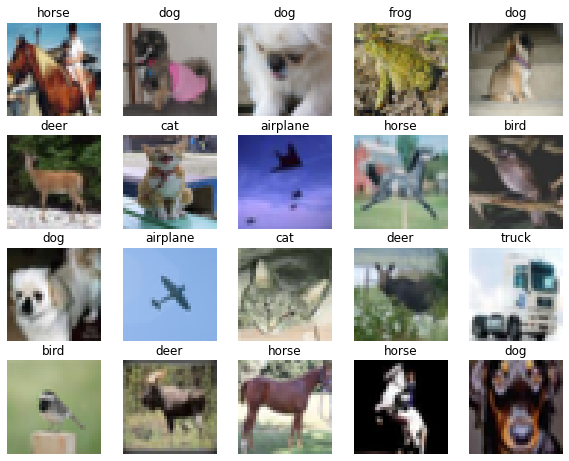

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
#plt.tight_layout()
for i in range(20):
    plt.subplot(5,5,i+1)
    #plt.xticks([])
    #plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], interpolation='none')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.show()

#### Prepare data

In [4]:
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


## Build a sequential AutoML pipeline

#### Build sequential model with Functional API

In [5]:
inputs = ak.ImageInput()
x = ak.Normalization()(inputs)
x = ak.ImageAugmentation()(x)
# Build a sequential AutoML pipeline using multiple AutoKeras built-in blocks(ak.ConvBlock).
x = ak.ConvBlock(
    num_blocks=kt.engine.hyperparameters.Choice('num_blocks', [2]),
    num_layers=kt.engine.hyperparameters.Choice('num_layers', [1]))(x)
x = ak.ConvBlock(
    num_blocks=kt.engine.hyperparameters.Choice('num_blocks', [2]),
    num_layers=kt.engine.hyperparameters.Choice('num_layers', [1]))(x)
x = ak.ConvBlock(
    num_blocks=kt.engine.hyperparameters.Choice('num_blocks', [2]),
    num_layers=kt.engine.hyperparameters.Choice('num_layers', [1]))(x)

outputs = ak.ClassificationHead(dropout=0.0)(x)

#### Search pipelines

In [6]:
clf = ak.AutoModel(
    inputs=inputs, 
    outputs=outputs,
    max_trials=10,
    overwrite=True,
    seed=42)

In [7]:
clf.fit(x_train, y_train, epochs=10) 

Trial 10 Complete [00h 01m 00s]
val_loss: 2.302013397216797

Best val_loss So Far: 1.2431323528289795
Total elapsed time: 00h 11m 45s
INFO:tensorflow:Oracle triggered exit


Epoch 1/10
313/313 [==============================] - 5s 13ms/step - loss: 2.0044 - accuracy: 0.2313
Epoch 2/10
313/313 [==============================] - 3s 11ms/step - loss: 1.7344 - accuracy: 0.3502
Epoch 3/10
313/313 [==============================] - 3s 11ms/step - loss: 1.6179 - accuracy: 0.3934
Epoch 4/10
313/313 [==============================] - 3s 11ms/step - loss: 1.5304 - accuracy: 0.4269
Epoch 5/10
313/313 [==============================] - 3s 11ms/step - loss: 1.4687 - accuracy: 0.4507
Epoch 6/10
313/313 [==============================] - 4s 11ms/step - loss: 1.4021 - accuracy: 0.4841
Epoch 7/10
313/313 [==============================] - 3s 11ms/step - loss: 1.3311 - accuracy: 0.5081
Epoch 8/10
313/313 [==============================] - 4s 12ms/step - loss: 1.2863 - accuracy: 0.5271
Epoch 9/10
313/313 [==============================] - 3s 11ms/step - loss: 1.2424 - accuracy: 0.5427
Epoch 10/10
313/313 [==============================] - 4s 11ms/step - loss: 1.2038 - accura

## Explore Model

In [8]:
# Get the summarized results during the tuning process (return the best 10 models if existed)
clf.tuner.results_summary()

Results summary
Results in .\auto_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
image_augmentation_1/translation_factor: 0.0
image_augmentation_1/horizontal_flip: True
image_augmentation_1/vertical_flip: True
image_augmentation_1/rotation_factor: 0.0
image_augmentation_1/zoom_factor: 0.0
image_augmentation_1/contrast_factor: 0.1
conv_block_1/kernel_size: 3
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 1
conv_block_1/filters_0_0: 32
conv_block_1/filters_1_0: 512
conv_block_2/kernel_size: 3
conv_block_2/separable: False
conv_block_2/max_pooling: True
conv_block_2/dropout: 0
conv_block_2/num_blocks: 2
conv_block_2/num_layers: 1
conv_block_2/filters_0_0: 32
conv_block_2/filters_1_0: 32
conv_block_3/kernel_size: 3
conv_block_3/separable: False
conv_block_3/max_pooling: True
conv_block_3/dropout: 0
conv_block_3/num_blocks: 2
conv_block_3/num_lay

In [9]:
#Retrieve best model
best_model = clf.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0     

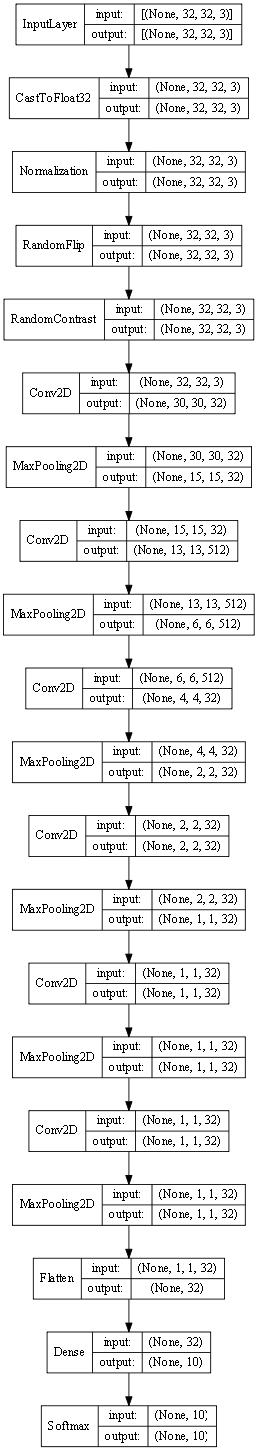

In [10]:
# Converts a Keras model to dot format and plot an image
tf.keras.utils.plot_model(best_model, show_layer_names=False, show_shapes=True, expand_nested=True, dpi=64)

## Retrain and evaluate searched model

In [12]:
(x_train, y_train), (x_test, y_test) =  cifar10.load_data()
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

# compile the model and train the model
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
best_model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.20)

Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)
Epoch 1/20
625/625 [==============================] - 8s 12ms/step - loss: 0.7911 - accuracy: 0.7200 - val_loss: 0.9191 - val_accuracy: 0.6772
Epoch 2/20
625/625 [==============================] - 7s 12ms/step - loss: 0.7599 - accuracy: 0.7298 - val_loss: 0.8917 - val_accuracy: 0.6854
Epoch 3/20
625/625 [==============================] - 8s 12ms/step - loss: 0.7361 - accuracy: 0.7377 - val_loss: 0.8852 - val_accuracy: 0.6900
Epoch 4/20
625/625 [==============================] - 7s 12ms/step - loss: 0.7176 - accuracy: 0.7431 - val_loss: 0.8557 - val_accuracy: 0.7029
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.7068 - accuracy: 0.7471 - val_loss: 0.8759 - val_accuracy: 0.6960
Epoch 6/20
625/625 [==============================] - 7s 11ms/step - loss: 0.6840 - accuracy: 0.7576 - val_loss: 0.8508 - val_accuracy: 0.7

#### Evaluate the searched model

In [13]:
# evaluate the model
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.8661 - accuracy: 0.7087
Test loss:  0.8660683631896973
Test accuracy:  0.7087000012397766


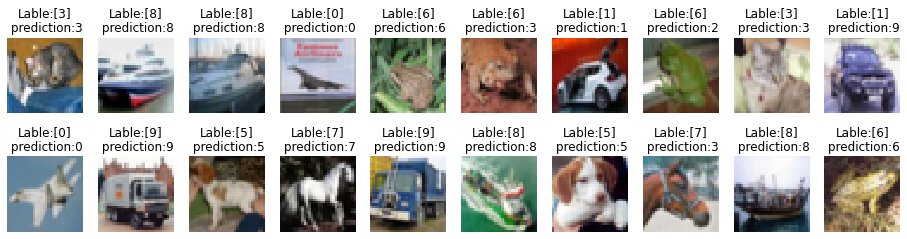

In [14]:
# make prediction and plot the results
y_predictions = best_model.predict( x_test[:32] ).argmax(axis = 1)

plt.figure( figsize=(16,4) )
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(x_test[i].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("Lable:{}\n prediction:{}".format(y_test[i], y_predictions[i]))
    plt.axis('off')

In [15]:
1-(4/100)

0.96